In [3]:
#!pip install mtcnn
#!unzip ../data/5-celebrity-faces-dataset.zip -d ../data
#!pip install 'h5py==2.10.0' --force-reinstall


In [4]:
import sys
sys.path.append("..")

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [5]:

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
from nets.detector_MTCNN import DetectorMTCNN
from nets import cnn_recognition

In [6]:
img_width, img_height = 224, 224
data_dir = '../data/5-celebrity-faces-dataset'
train_data = os.path.join(data_dir, 'train')
validation_data = os.path.join(data_dir, 'val')
train_data_dir = os.path.join(data_dir, 'train_align')
validation_data_dir = os.path.join(data_dir, 'val_align')
nb_train_samples = 93
nb_validation_samples = 25
epochs = 50
batch_size = 2
numclasses = 5
IMG_SHAPE = (img_width, img_height, 3)

In [7]:

detector_MTCNN = DetectorMTCNN(img_width, img_height)

In [8]:
detector_MTCNN.crop_align(train_data, train_data_dir)
detector_MTCNN.crop_align(validation_data, validation_data_dir)

In [9]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,
    # randomly rotate images in the range (degrees, 0 to 180)
    rotation_range=10,
    zoom_range=0.1,  # Randomly zoom image
    # randomly shift images horizontally (fraction of total width)
    width_shift_range=0.1,
    # randomly shift images vertically (fraction of total height)
    height_shift_range=0.1,
    # shear_range=0.2,
    vertical_flip=False,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')


Found 93 images belonging to 5 classes.
Found 25 images belonging to 5 classes.


In [10]:
# Triggering a training generator for all the batches
for image_batch, label_batch in train_generator:
    break

# This will print all classification labels in the console
print(train_generator.class_indices)

# Creating a file which will contain all names in the format of next lines
labels = '\n'.join(sorted(train_generator.class_indices.keys()))

# Writing it out to the file which will be named 'labels.txt'
with open('../models/labels.txt', 'w') as f:
    f.write(labels)


{'ben_afflek': 0, 'elton_john': 1, 'jerry_seinfeld': 2, 'madonna': 3, 'mindy_kaling': 4}


In [11]:
cnn_recognition_net = cnn_recognition.Net()

In [12]:
cnn_recognition_net.model.compile(optimizer=tf.keras.optimizers.Adam(),  loss='categorical_crossentropy',   metrics=['accuracy']) 

cnn_recognition_net.model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 165       
Total params: 2,626,821
Trainable params: 368,837
Non-trainable params: 2,257,984
_________________________________________________________________


In [13]:
print('Number of trainable variables = {}'.format(
    len(cnn_recognition_net.model.trainable_variables)))


Number of trainable variables = 4


In [14]:
nb_train_samples = 93
nb_validation_samples = 25
batch_size = 32
initial_epochs = 10

history = cnn_recognition_net.model.fit(train_generator, epochs=initial_epochs,
                    validation_data=validation_generator)


Epoch 1/10
47/47 [==============================] - 5s 59ms/step - loss: 2.1434 - accuracy: 0.2258 - val_loss: 1.5744 - val_accuracy: 0.3200
Epoch 2/10
47/47 [==============================] - 3s 61ms/step - loss: 1.5662 - accuracy: 0.3548 - val_loss: 1.4681 - val_accuracy: 0.2800
Epoch 3/10
47/47 [==============================] - 2s 53ms/step - loss: 1.4148 - accuracy: 0.3548 - val_loss: 1.4044 - val_accuracy: 0.3600
Epoch 4/10
47/47 [==============================] - 3s 54ms/step - loss: 1.3551 - accuracy: 0.4086 - val_loss: 1.3780 - val_accuracy: 0.4000
Epoch 5/10
47/47 [==============================] - 3s 53ms/step - loss: 1.2918 - accuracy: 0.4839 - val_loss: 1.3480 - val_accuracy: 0.3600
Epoch 6/10
47/47 [==============================] - 3s 53ms/step - loss: 1.2136 - accuracy: 0.4516 - val_loss: 1.4532 - val_accuracy: 0.3200
Epoch 7/10
47/47 [==============================] - 3s 57ms/step - loss: 1.1495 - accuracy: 0.5161 - val_loss: 1.1999 - val_accuracy: 0.4400
Epoch 8/10
47

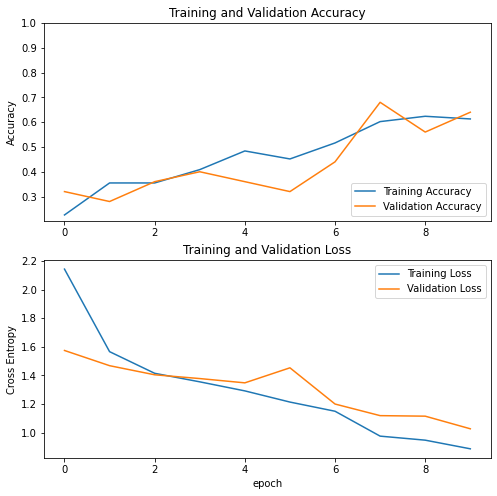

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [16]:
# Setting back to trainable
cnn_recognition_net.base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(cnn_recognition_net.base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in cnn_recognition_net.base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compile the model
# Compile the model using a much lower training rate.
# Notice the parameter in Adam() function, parameter passed to Adam is the learning rate
cnn_recognition_net.model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

# Getting the summary of the final model
cnn_recognition_net.model.summary()
# Printing Training Variables
print('Number of trainable variables = {}'.format(
    len(cnn_recognition_net.model.trainable_variables)))
fine_tune_epochs = 5
total_epochs = initial_epochs + fine_tune_epochs

# Continue Train the model
history_fine = cnn_recognition_net.model.fit(train_generator,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_generator)


Number of layers in the base model:  154
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 165       
Total params: 2,626,821
Trainable params: 2,230,277
Non-trainable params: 396,544
_________________________________________________________________
Number of trainable variables = 58
Epoch 10/15
47/47 [===========

In [17]:
saved_model_dir = '../models/fine_tuning'
cnn_recognition_net.model.save(saved_model_dir)
print("Model Saved to ../models/fine_tuning")

/home/jarvis/anaconda3/envs/tcc/lib/python3.6/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ../models/fine_tuning/assets


INFO:tensorflow:Assets written to: ../models/fine_tuning/assets


Model Saved to ../models/fine_tuning


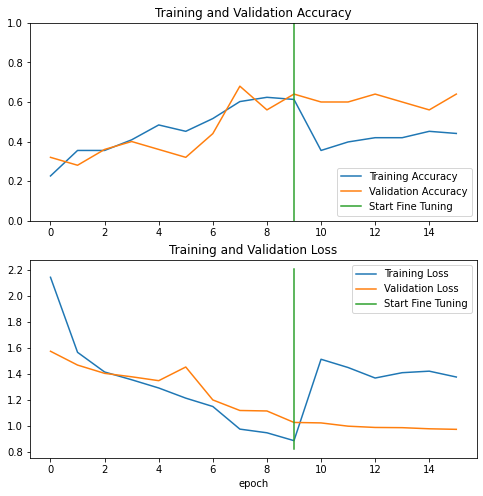

In [18]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
#plt.ylim([0, 1.0])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [19]:
reconstructed_model = tf.keras.models.load_model(saved_model_dir)

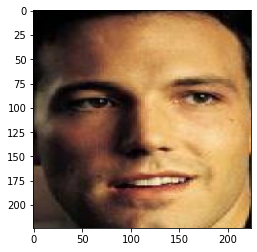

In [20]:
img_path = '../data/5-celebrity-faces-dataset/val_align/ben_afflek/httpabsolumentgratuitfreefrimagesbenaffleckjpg.jpg'
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.show()


In [21]:
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)
prediction = reconstructed_model.predict(img_batch)
predicted_class = np.argmax(prediction[0])
print(predicted_class)


2


In [22]:
labels_path = '../models/labels.txt'
imagenet_labels = np.array(open(labels_path).read().splitlines())
predicted_class_name = imagenet_labels[predicted_class]
print(predicted_class_name)


jerry_seinfeld
